# This is the file containing the whole code

In [12]:
import numpy as np
import pandas as pd
from math import sqrt,ceil, floor
from tqdm import tqdm
import matplotlib.pyplot as plt

### Our first framework is the two-regime model economy. The four-regime model will follow. Finally, we will use our tree on Heston model

# First, let us build the recombining tree

In [2]:
def arbre_recomb(n,b): #We will consider a tree where the variations of x go from -b to b (this corresponds to li values)
    l=2*b*n+1           #We will then multiply those variations by sigma_bar and the square root of h to match the formulas
    S=np.zeros((l,n+1))
    for i in range(l):
        S[i,n]= b*n-i
    for j in range(1,n+1):
        for i in  range(l):
            if i>=b*j and i<=b*(2*n-j):
                S[i,n-j]=b*n-i
    return S

In [3]:
arbre1=arbre_recomb(1000,2) # Now you can create the recombining tree

In [4]:
# Here we define the probabilities of different moves in each regime
# We will create a 3xm matrix where m is the number of regimes
def proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n): 
    proba=np.zeros((3,len(List_sigma)))
    h=T/n
    for i in range(len(List_sigma)):
        proba[0,i]=(List_sigma[i]**2+List_a[i]*Liste_saut[i]*sigma_bar*np.sqrt(h)+h*List_a[i]**2)/(2*(Liste_saut[i]*sigma_bar)**2)
        proba[1,i]=(List_sigma[i]**2-List_a[i]*Liste_saut[i]*sigma_bar*np.sqrt(h)+h*List_a[i]**2)/(2*(Liste_saut[i]*sigma_bar)**2)
        proba[2,i]=1-(proba[0,i]+proba[1,i])
    return proba

In [5]:
# Here we compute the transition matrix using the generator matrix and the step h
def transition_matrix(Q,h):
    nbr=Q.shape[0]
    tr_matrix=np.zeros((nbr,nbr))
    for i in range(nbr):
        for j in range(nbr):
            if i==j:
                tr_matrix[i,j]=np.exp(Q[i,j]*h)
            else:
                tr_matrix[i,j]=-(1-np.exp(Q[i,i]*h))*Q[i,j]/Q[i,i]
    return tr_matrix

# Two-regime model

We first define the parameters used in the two-regime model


In [6]:
m1 = 2 # Number of regimes

# Now the lists of parameters depending on the regimes
list_sigma1=[0.15,0.25]
list_r1 = [0.05, 0.05]
list_a1=[list_r1[i]-0.5*list_sigma1[i]**2 for i in range(m1)]

# The constant sigma_bar1
sigma_bar1 = 0.2

# Define the li so that the probabilities of up,middle, down are all positives
L = [0]*m1
for i in range (m1):
    k1,k2 = floor(2*list_sigma1[i]/sigma_bar1),ceil(2*list_sigma1[i]/sigma_bar1)
    if k1==k2 or k1*sigma_bar1<list_sigma1[i]:
        L[i] = k2
    else:
        c = ((k1*sigma_bar1)**2-list_sigma1[i]**2)/list_a1[i]**2
        d = (k2*sigma_bar1-sqrt((k2*sigma_bar1)**2-4*list_sigma1[i]**2))**2/(4*list_a1[i])**2
        if c<=d:
            L[i] = k2
        else:
            L[i] = k1
print("The increments Li", L)

# Define the generator matrix and the transition matrix
Q1=np.array([[-0.5,0.5],[0.5,-0.5]])
P1=transition_matrix(Q1,1/1000) # notice that if one may want to change the step h, they may change T or n.

The increments Li [1, 2]


### We can now compute our options prices in this two-regime economy

In [7]:
def prix_call_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P, arbre): #list_saut is the li list
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma))) # Let us initialize our matrix

    # What is next is a straightforward application of the formulas given in the paper
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j,etat] += P[etat,k]*(table_prix[i-saut,n-j+1,k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1,k]*proba_umd[1,etat]+table_prix[i,n-j+1,k]*proba_umd[2,etat])
                    table_prix[i,n-j,etat]=np.exp(-r*h)*table_prix[i,n-j,etat]
        
    return table_prix

In [59]:
A1=prix_call_europeen(100,94,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
A2=prix_call_europeen(100,96,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
A3=prix_call_europeen(100,98,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
A4=prix_call_europeen(100,100,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
A5=prix_call_europeen(100,102,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
A6=prix_call_europeen(100,104,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
A7=prix_call_europeen(100,106,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)



In [68]:
# We will now print the prices table
A = [A1, A2, A3, A4, A5, A6, A7]
Df = pd.DataFrame({'S0':[i for i in range(94,107,2)], 'Tree':[B[2000,0] for B in A]}) 
Df #The prices will be printed as a list on each row, where the index i represents the regime i+1

,S0,Tree
0,94,"[5.86121169713768, 8.228404386030418]"
1,96,"[6.923020326921834, 9.317382007445124]"
2,98,"[8.083383992632376, 10.477573544944184]"
3,100,"[9.338299622468098, 11.704247134436248]"
4,102,"[10.683620427004527, 13.000574946330795]"
5,104,"[12.111348355527737, 14.356138588476941]"
6,106,"[13.61462223374124, 15.772456149244976]"


In [8]:
def prix_put_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P, arbre): #list_saut is the li list
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma))) # Let us initialize our matrix

    # What is next is a straightforward application of the formulas given in the paper
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j,etat] += P[etat,k]*(table_prix[i-saut,n-j+1,k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1,k]*proba_umd[1,etat]+table_prix[i,n-j+1,k]*proba_umd[2,etat])
                    table_prix[i,n-j,etat]=np.exp(-r*h)*table_prix[i,n-j,etat]
        
    return table_prix

In [9]:
def prix_call_americain(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P, arbre): #list_saut is the li list
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma))) # Let us initialize our matrix

    # What is next is a straightforward application of the formulas given in the paper
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j,etat] += P[etat,k]*(table_prix[i-saut,n-j+1,k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1,k]*proba_umd[1,etat]+table_prix[i,n-j+1,k]*proba_umd[2,etat])
                    table_prix[i,n-j,etat]= max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)), np.exp(-r*h)*table_prix[i,n-j,etat])
        
    return table_prix

In [10]:
def prix_put_americain(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P, arbre): #list_saut is the li list
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma))) # Let us initialize our matrix

    # What is next is a straightforward application of the formulas given in the paper
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j,etat] += P[etat,k]*(table_prix[i-saut,n-j+1,k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1,k]*proba_umd[1,etat]+table_prix[i,n-j+1,k]*proba_umd[2,etat])
                    table_prix[i,n-j,etat]= max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)), np.exp(-r*h)*table_prix[i,n-j,etat])
        
    return table_prix

In [65]:
C1=prix_put_americain(100,94,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
C2=prix_put_americain(100,96,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
C3=prix_put_americain(100,98,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
C4=prix_put_americain(100,100,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
C5=prix_put_americain(100,102,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
C6=prix_put_americain(100,104,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)
C7=prix_put_americain(100,106,1000,2,sigma_bar1,1,list_sigma1,list_a1,L,list_r1,P1, arbre1)

In [67]:
# Print the prices table
C=[C1, C2, C3, C4, C5, C6, C7]
Df2 = pd.DataFrame({'S0':[i for i in range(94,107,2)], 'Tree':[B[2000,0] for B in C]})
Df2

,S0,Tree
0,94,"[7.887341803269553, 10.246044855314704]"
1,96,"[6.761619788250978, 9.211130469447333]"
2,98,"[5.77279975983544, 8.263628289981797]"
3,100,"[4.909105962224006, 7.397754729040091]"
4,102,"[4.15974578321561, 6.6126611028022015]"
5,104,"[3.5125898797011983, 5.898792664675986]"
6,106,"[2.9567023364071985, 5.254773500702386]"


# Four-regime model

In [69]:
arbre2=arbre_recomb(1000,4) # We will use this new tree for this model

Now, we will define the parameters used in the four-regime model

In [70]:
m2 = 4 # Number of regimes

# Now the lists of parameters depending on the regimes
list_sigma2=[0.9, 0.5, 0.7, 0.2]
list_r2 = [0.02, 0.1, 0.06, 0.15]
list_a2=[list_r2[i]-0.5*list_sigma2[i]**2 for i in range(m2)]
# The constant sigma_bar2
sigma_bar2 = 0.4

# Define the li so that the probabilities of up,middle, down are all positives
L2 = [0]*m2
for i in range (m2):
    k1,k2 = floor(2*list_sigma2[i]/sigma_bar2),ceil(2*list_sigma2[i]/sigma_bar2)
    if k1==k2 or k1*sigma_bar2<list_sigma2[i]:
        L2[i] = k2
    else:
        c = ((k1*sigma_bar2)**2-list_sigma2[i]**2)/list_a2[i]**2
        d = (k2*sigma_bar2-sqrt((k2*sigma_bar2)**2-4*list_sigma2[i]**2))**2/(4*list_a2[i])**2
        if c<=d:
            L2[i] = k2
        else:
            L2[i] = k1
print("The increments Li", L2)

# Define the generator matrix and the transition matrix
Q2 = np.ones((m2,m2))/3
for i in range(m2):
    Q2[i,i] = -1
P2=transition_matrix(Q2,1/1000) # notice that if one may want to change the step h, they may change T or n.

The increments Li [4, 2, 3, 1]


In [71]:
D1=prix_put_americain(100,80,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
D2=prix_put_americain(100,90,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
D3=prix_put_americain(100,100,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
D4=prix_put_americain(100,110,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
D5=prix_put_americain(100,120,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)

In [77]:
# Print the American put prices table
D=[D1, D2, D3, D4, D5]
Df3 = pd.DataFrame({'S0':[i for i in range(80,121,10)], 'Tree':[np.round(B[4000,0],4) for B in D]}) # here b*n = 4000
Df3

,S0,Tree
0,80,"[36.4502, 26.5974, 31.3615, 20.7283]"
1,90,"[32.1161, 21.5811, 26.7184, 14.7419]"
2,100,"[28.4185, 17.5913, 22.8527, 10.9462]"
3,110,"[25.2605, 14.4257, 19.6395, 8.4703]"
4,120,"[22.5491, 11.9033, 16.9516, 6.7792]"


In [74]:
E1=prix_put_europeen(100,80,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
E2=prix_put_europeen(100,90,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
E3=prix_put_europeen(100,100,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
E4=prix_put_europeen(100,110,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)
E5=prix_put_europeen(100,120,1000,4,sigma_bar2,1,list_sigma2,list_a2,L2,list_r2,P2, arbre2)

In [78]:
# Print the European put prices table
E=[E1, E2, E3, E4, E5]
Df4 = pd.DataFrame({'S0':[i for i in range(80,121,10)], 'Tree':[np.round(B[4000,0],4) for B in E]}) # Here b*n = 4000
Df4

,S0,Tree
0,80,"[34.8479, 24.5996, 29.5966, 18.2138]"
1,90,"[30.8064, 20.184, 25.3549, 13.6292]"
2,100,"[27.3398, 16.5983, 21.788, 10.3961]"
3,110,"[24.3646, 13.7086, 18.7998, 8.1604]"
4,120,"[21.7982, 11.3763, 16.281, 6.5799]"


# Heston model with stochastic volatility

In [85]:
# Parameters for the Heston model
kappa = 3.0
theta = 0.04
sigma_v = 0.1
rho = -0.1 # covariance between price and volatility brownian motions
v0 = 0.04
sigma_bar = 0.2

# Discretisation
dw = 0.02

In [91]:
arbre3=arbre_recomb(2500,3)

We will generate the Markov chain

In [92]:
# upper and lower bounds for the discretization of the volatility
ml, mu=  15, 40
m = mu-ml+1
regimes = range(1,m+1)

def transition(k):

    forward = sigma_v**2/(2*(dw)**2) + (2*kappa*theta-(sigma_v**2)/2)/(2*k*(dw)**2) - kappa*k/4

    backward = sigma_v**2/(2*(dw)**2) - (2*kappa*theta-(sigma_v**2)/2)/(2*k*(dw)**2) + kappa*k/4

    return forward,backward


def compute_Q():
    
    Q = np.zeros((m,m))

    for i in range(1,m-1):
        
        forward,backward = transition(i+ml-1)

        if forward>=0 and backward>=0:

            Q[i,i+1] = forward
            Q[i,i-1] = backward
            Q[i,i] = -(forward+backward)

        elif forward>0:

            Q[i,i-1] = backward + kappa*(i+ml-1)/4
            Q[i,i+1] = sigma_v**2/(2*(dw)**2) 
            Q[i,i] = -forward-backward

        else:
            
            Q[i,i-1] = sigma_v**2/(2*(dw)**2) 
            Q[i,i+1] = forward - kappa*(i+ml-1)/4
            Q[i,i] = -forward-backward
    # i =0
    Q[0,1] = (2*kappa*theta-(sigma_v**2)/2)/(ml*(dw)**2) - kappa*ml/2
    Q[0,0] = - Q[0,1]
    # i = m-1
    Q[m-1,m-2] = -(2*kappa*theta-(sigma_v**2)/2)/(mu*(dw)**2) + kappa*mu/2
    Q[m-1,m-1] = - Q[m-1,m-2]

    return Q

In [93]:
Q3 = compute_Q()
P3 = transition_matrix(Q3, 0.25/2500)

In [94]:
list_vi = [(1/4)*((i+ml-1)*dw)**2 for i in range(1,m+1)]
list_sigma = [np.sqrt(list_vi[i]*(1-rho**2)) for i in range(len(list_vi))]
list_a = [list_vi[i]*((rho*kappa/sigma_v)-0.5) for i in range(len(list_vi))]
list_r = [0.05]*m

list_saut = [0]*m
for i in range (m):
    k1,k2 = floor(2*list_sigma[i]/sigma_bar),ceil(2*list_sigma[i]/sigma_bar)
    if k1==k2 or k1*sigma_bar<list_sigma[i]:
        list_saut[i] = k2
    else:
        c = ((k1*sigma_bar)**2-list_sigma[i]**2)/list_a[i]**2
        d = (k2*sigma_bar-sqrt((k2*sigma_bar)**2-4*list_sigma[i]**2))**2/(4*list_a[i])**2
        if c<=d:
            list_saut[i] = k2
        else:
            list_saut[i] = k1

In [97]:
def prix_call_europeen_Heston_model(K, S_o, n, b, sigma_bar, T,List_vi, List_sigma, List_a, Liste_saut, List_r, Q, arbre):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Matrix initialization

    # We will then use the formulas in the paper
    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] =  max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0)
    new_table_prix = np.zeros((len(List_sigma), l))         
    for j in range(1, n + 1):
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    prix_somme += table_prix[etat, i - saut] * proba_umd[0, etat] + \
                                      table_prix[etat, i + saut] * proba_umd[1, etat] + \
                                      table_prix[etat, i] * (proba_umd[2, etat] + Q[etat, etat] * h)
        
                    if etat != 0 and etat != len(List_sigma)-1:
                        prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i] + Q[etat, etat+1] * h * table_prix[etat+1, i] 
                    else:
                        if etat ==0 :
                            prix_somme += Q[etat, etat+1] * h * table_prix[etat+1, i]
                        if etat== len(List_sigma)-1:
                            prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i]
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix, new_table_prix = new_table_prix, table_prix  # Replace the old matrix with the new one

    return table_prix

In [ ]:
F1 = prix_call_europeen_Heston_model(100,90,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r, Q3, arbre3)

In [98]:
def prix_put_americain_Heston_model(K, S_o, n, b, sigma_bar, T,List_vi, List_sigma, List_a, Liste_saut, List_r, Q, arbre):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Matrix initialization

    # We will then use the formulas in the paper
    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] =  max(K-S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0)
    new_table_prix = np.zeros((len(List_sigma), l))         
    for j in range(1, n + 1):
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    prix_somme += table_prix[etat, i - saut] * proba_umd[0, etat] + \
                                      table_prix[etat, i + saut] * proba_umd[1, etat] + \
                                      table_prix[etat, i] * (proba_umd[2, etat] + Q[etat, etat] * h)
        
                    if etat != 0 and etat != len(List_sigma)-1:
                        prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i] + Q[etat, etat+1] * h * table_prix[etat+1, i] 
                    else:
                        if etat ==0 :
                            prix_somme += Q[etat, etat+1] * h * table_prix[etat+1, i]
                        if etat== len(List_sigma)-1:
                            prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i]
                    new_table_prix[etat, i] = max(K-S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h), np.exp(-r * h) * prix_somme)
        table_prix, new_table_prix = new_table_prix, table_prix  # Replace the old matrix with the new one

    return table_prix

### Here we test our tree's performance. The first criterion is the price convergence in the two-regime model. We will later show the sensitivity to the parameter sigma_bar in the same model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


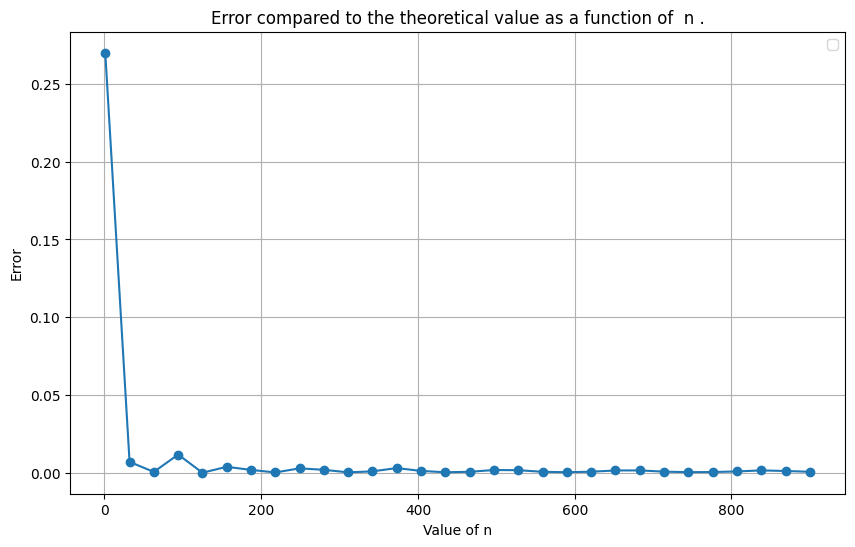

In [13]:
# Define the values of n
n_values = np.linspace(1, 900, 30, dtype=int)

# Define the parameters needed to run the pricing function
K = 100
S_o = 94
truth = 5.8620

# Now we create our plot
plt.figure(figsize=(10, 6))
R=[]

# Compute the prices with the values of n defined earlier
for n in n_values:
    P=transition_matrix(Q1,1/n)
    arbre_n=arbre_recomb(n,2)
    A1 = prix_call_europeen(K, S_o, n, 2, 0.2, 1, list_sigma1, list_a1, L, list_r1, P, arbre_n)[:,0][n*2][0]
    R.append(A1)

plt.plot(n_values, np.abs(truth-np.array(R)), marker = "o") # We will plot the absolute error of our tree


plt.xlabel('Value of n')
plt.ylabel('Error')
plt.title('Error compared to the theoretical value as a function of  n .')
plt.legend()


plt.grid(True)
plt.show()

### Now let us look at the sensitivity to sigma_bar

Since the dividends d1 and d2 are considered in this part, we will just change the values of list_a

In [18]:
# d1 = d2 = 0.04
list_a3 = [list_r1[i]-0.04 -0.5*list_sigma1[i]**2 for i in range(m1)]

# Define the lists of b and sigma_bar with which we will test the sensitivity
list_b = [1, 2, 2, 3, 5]
list_sigma_bar = [0.3, 0.25, 0.2, 0.15, 0.1]

In [36]:
EC = []
for s in range(90,111,10):
    for i in range(1,3):
        EC1 = prix_call_europeen(100,s,1000,2, list_sigma_bar[i], 1,list_sigma1,list_a3,L,list_r1,P1, arbre1)[2000,0]
        EC.append(EC1)

In [71]:
AC = []
for s in range(90,111,10):
    for i in range(1,3):
        AC1 = prix_call_americain(100,s,1000,2, list_sigma_bar[i], 1,list_sigma1,list_a3,L,list_r1,P1, arbre1)[2000,0]
        AC.append(AC1)

In [91]:
EP = []
for s in range(90,111,10):
    for i in range(1,3):
        EP1 = prix_put_europeen(100,s,1000,2, list_sigma_bar[i], 1,list_sigma1,list_a3,L,list_r1,P1, arbre1)[2000,0]
        EP.append(EP1)

In [92]:
AP = []
for s in range(90,111,10):
    for i in range(1,3):
        AP1 = prix_put_americain(100,s,1000,2, list_sigma_bar[i], 1,list_sigma1,list_a3,L,list_r1,P1, arbre1)[2000,0]
        AP.append(AP1)

In [103]:
# We will first print the prices table for regime 1
Df5 = pd.DataFrame({
    'Option type': ['EC']*3+['AC']*3+['EP']*3+['AP']*3, 
    'S0': [90, 100, 110]*4,
    'sigma_bar=0.2 & b=2':[np.round(EC[i][0],4) for i in range(1,6,2)]+[np.round(AC[i][0],4) for i in range(1,6,2)]+[np.round(EP[i][0],4) for i in range(1,6,2)]+[np.round(AP[i][0],4) for i in range(1,6,2)],
    'sigma_bar=0.25 & b=2':[np.round(EC[i][0],4) for i in range(0,5,2)]+[np.round(AC[i][0],4) for i in range(0,5,2)]+[np.round(EP[i][0],4) for i in range(0,5,2)]+[np.round(EP[i][0],4) for i in range(0,5,2)]
    
                    })
display(Df5)

,Option type,S0,sigma_bar=0.2 & b=2,sigma_bar=0.25 & b=2
0,EC,90,2.7884,2.7884
1,EC,100,6.9659,6.9651
2,EC,110,13.3741,13.3735
3,AC,90,2.7902,2.7901
4,AC,100,6.9741,6.9733
5,AC,110,13.4046,13.4041
6,EP,90,11.4403,11.4403
7,EP,100,6.0099,6.0091
8,EP,110,2.8102,2.8096
9,AP,90,11.8090,11.4403


In [104]:
# Now we print the prices table for regime 2
Df6 = pd.DataFrame({
    'Option type': ['EC']*3+['AC']*3+['EP']*3+['AP']*3, 
    'S0': [90, 100, 110]*4,
    'sigma_bar=0.2':[np.round(EC[i][1],4) for i in range(1,6,2)]+[np.round(AC[i][1],4) for i in range(1,6,2)]+[np.round(EP[i][1],4) for i in range(1,6,2)]+[np.round(AP[i][1],4) for i in range(1,6,2)],
    'sigma_bar=0.25':[np.round(EC[i][1],4) for i in range(0,5,2)]+[np.round(AC[i][1],4) for i in range(0,5,2)]+[np.round(EP[i][1],4) for i in range(0,5,2)]+[np.round(AP[i][1],4) for i in range(0,5,2)]
    
                    })
display(Df6)

,Option type,S0,sigma_bar=0.2,sigma_bar=0.25
0,EC,90,4.8058,4.8056
1,EC,100,9.3602,9.3588
2,EC,110,15.5471,15.5444
3,AC,90,4.8143,4.8142
4,AC,100,9.3870,9.3856
5,AC,110,15.6154,15.6127
6,EP,90,13.4577,13.4575
7,EP,100,8.4042,8.4028
8,EP,110,4.9832,4.9805
9,AP,90,13.8507,13.8501
